In [1]:
# 1. Imports
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# make plots appear larger in Colab notebooks
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 12


In [4]:
# 2. Load JSON file (assumes Netflix.json is in current working directory or uploaded to Colab)
with open('Netflix.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)   # convert list-of-dicts to DataFrame
print("Rows, columns:", df.shape)
df.head()


Rows, columns: (200, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,None,United States,25-Sep-21,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,None,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,24-Sep-21,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",None,24-Sep-21,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,None,None,None,24-Sep-21,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,None,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,24-Sep-21,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [5]:
# 3. Quick inspection
df.info()
df.describe(include='all').T   # basic summary for each column


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       200 non-null    object
 1   type          200 non-null    object
 2   title         200 non-null    object
 3   director      137 non-null    object
 4   cast          180 non-null    object
 5   country       136 non-null    object
 6   date_added    200 non-null    object
 7   release_year  200 non-null    int64 
 8   rating        200 non-null    object
 9   duration      200 non-null    object
 10  listed_in     200 non-null    object
 11  description   200 non-null    object
dtypes: int64(1), object(11)
memory usage: 18.9+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
show_id,200,200,s1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,200,2,Movie,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,200,200,Dick Johnson Is Dead,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,137,123,Toshiya Shinohara,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cast,180,179,"Vijay Sethupathi, Parthiban, Raashi Khanna",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,136,44,United States,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_added,200,26,1-Sep-21,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_year,200.0,NaN,NaN,NaN,2012.23,11.609089,1961.0,2005.75,2018.0,2021.0,2021.0
rating,200,10,TV-MA,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,200,71,1 Season,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# 4. Standardize column names and strip whitespace strings
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

# strip leading/trailing whitespace for string columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('string').str.strip()



In [8]:
# 5. Parse date_added into datetime
# Some rows might be null, so coerce errors into NaT
df['date_added_parsed'] = pd.to_datetime(df['date_added'], dayfirst=False, errors='coerce', format='%d-%b-%y')

# fallback: try more forgiving parse when format differs
mask_na = df['date_added_parsed'].isna() & df['date_added'].notna()
if mask_na.any():
    df.loc[mask_na, 'date_added_parsed'] = pd.to_datetime(df.loc[mask_na, 'date_added'], errors='coerce')

# extract year and month for EDA
df['added_year'] = df['date_added_parsed'].dt.year
df['added_month'] = df['date_added_parsed'].dt.month


In [9]:
# 6. Normalize duration: separate numeric and unit (e.g., "90 min", "2 Seasons")
def parse_duration(d):
    if pd.isna(d):
        return (np.nan, np.nan)
    s = str(d).strip()
    parts = s.split()
    # common formats: "90 min", "2 Seasons", "1 Season"
    try:
        num = float(parts[0])
    except:
        # sometimes duration is like "100 min"
        return (np.nan, np.nan)
    unit = ' '.join(parts[1:]) if len(parts) > 1 else ''
    return (num, unit.lower())

dur_parsed = df['duration'].apply(parse_duration)
df[['duration_num', 'duration_unit']] = pd.DataFrame(dur_parsed.tolist(), index=df.index)



In [10]:
# 7. Convert comma-separated strings into lists for cast, country and listed_in (genres)
def split_to_list(s):
    if pd.isna(s):
        return []
    return [x.strip() for x in str(s).split(',') if x.strip()]

df['cast_list'] = df['cast'].apply(split_to_list)
df['country_list'] = df['country'].apply(split_to_list)
df['genres'] = df['listed_in'].apply(split_to_list)


In [11]:
# 8. Missing values overview
missing_counts = df.isna().sum().sort_values(ascending=False)
print(missing_counts.head(15))

# Strategy examples:
# - For 'director' and 'cast', keep NaN/empty to indicate unknown (we converted to empty lists)
# - For analysis, treat empty country_list as 'Unknown'
df['primary_country'] = df['country_list'].apply(lambda x: x[0] if len(x)>0 else 'Unknown')

# - For added_year, if missing but release_year exists, set added_year = release_year (approximation)
mask_added_na = df['added_year'].isna() & df['release_year'].notna()
df.loc[mask_added_na, 'added_year'] = df.loc[mask_added_na, 'release_year']


country              64
director             63
cast                 20
show_id               0
title                 0
type                  0
date_added            0
release_year          0
rating                0
duration              0
listed_in             0
description           0
date_added_parsed     0
added_year            0
added_month           0
dtype: int64


/tmp/ipython-input-1585459167.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[mask_added_na, 'added_year'] = df.loc[mask_added_na, 'release_year']


In [12]:
# 9. Duplicates handling
# Option 1: duplicates by show_id (unique key) -> drop duplicates keeping first
dups_by_id = df.duplicated(subset=['show_id']).sum()
print("Duplicates by show_id:", dups_by_id)
df = df.drop_duplicates(subset=['show_id'], keep='first')

# Option 2: duplicates by title + release_year (sometimes same item repeated)
dups_by_title_year = df.duplicated(subset=['title','release_year']).sum()
print("Duplicates by title+release_year before:", dups_by_title_year)
df = df.drop_duplicates(subset=['title','release_year'], keep='first')
print("Rows after deduplication:", df.shape[0])


Duplicates by show_id: 0
Duplicates by title+release_year before: 0
Rows after deduplication: 200


In [13]:
# 10a. Type distribution (Movie vs TV Show)
type_counts = df['type'].value_counts()
print(type_counts)

# 10b. Rating distribution
rating_counts = df['rating'].value_counts().head(20)
print(rating_counts)

# 10c. Top 15 countries
country_counts = df['primary_country'].value_counts().head(15)
print(country_counts)


type
Movie      127
TV Show     73
Name: count, dtype: Int64
rating
TV-MA    50
TV-14    34
PG-13    28
R        23
TV-PG    22
TV-Y7    14
PG       13
TV-Y     10
TV-G      5
G         1
Name: count, dtype: Int64
primary_country
Unknown           64
United States     62
India             15
Japan             14
United Kingdom    12
Australia          4
Nigeria            4
South Africa       3
Germany            3
France             3
South Korea        3
China              2
Spain              2
Finland            1
Turkey             1
Name: count, dtype: int64


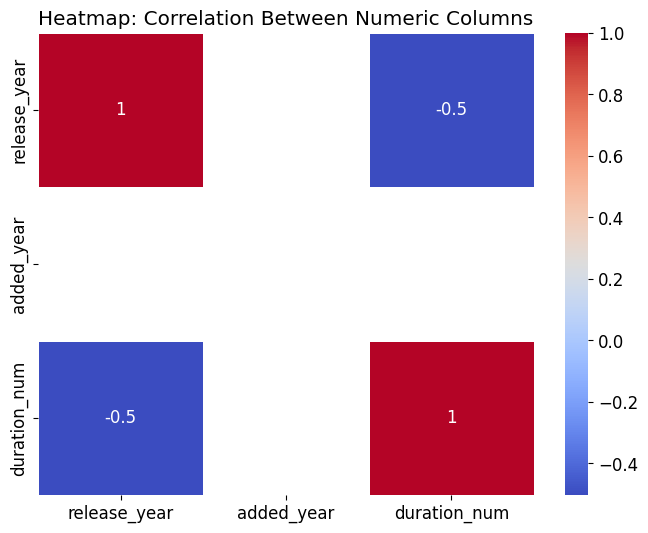

✅ Visualizations generated successfully.


In [19]:
# ------------------------------------------------------------
# 11. ADVANCED VISUALIZATIONS (HEATMAPS + INTERACTIVE PLOTS)
# ------------------------------------------------------------

# 11a. Numeric Correlation Heatmap (Seaborn)
numeric_cols = ['release_year','added_year','duration_num']
corr = df[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap: Correlation Between Numeric Columns')
plt.show()

# 11b. Interactive Heatmap: Rating vs Type
type_rating = pd.crosstab(df['rating'], df['type'])
fig = px.imshow(
    type_rating,
    color_continuous_scale='magma',
    title='Interactive Heatmap: Rating vs Type Frequency',
    labels=dict(x="Type", y="Rating", color="Count")
)
fig.update_layout(xaxis_side='top')
fig.show()

# 11c. Interactive 3D Scatter: Release Year vs Duration vs Added Year
mask = df['duration_num'].notna() & df['release_year'].notna()
subset = df.loc[mask & (df['duration_num'] < 300)].copy()

fig = px.scatter_3d(
    subset,
    x='release_year',
    y='duration_num',
    z='added_year',
    color='type',
    hover_data=['title','rating'],
    title='3D Scatter: Release Year vs Duration vs Added Year (by Type)',
    color_discrete_map={'Movie':'red','TV Show':'blue'}
)
fig.update_traces(marker=dict(size=4, opacity=0.7))
fig.update_layout(scene=dict(
    xaxis_title='Release Year',
    yaxis_title='Duration (minutes)',
    zaxis_title='Added Year'
))
fig.show()

# 11d. Interactive Grouped Bar Chart: Titles Added per Year by Type
year_type_counts = df.groupby(['added_year','type']).size().reset_index(name='count')
year_type_counts = year_type_counts.dropna(subset=['added_year'])

fig = px.bar(
    year_type_counts,
    x='added_year',
    y='count',
    color='type',
    barmode='group',
    title='Titles Added per Year by Type',
    labels={'added_year':'Added Year','count':'Number of Titles','type':'Content Type'},
    color_discrete_map={'Movie':'crimson','TV Show':'royalblue'}
)
fig.update_layout(
    xaxis=dict(tickmode='linear'),
    width=900,
    height=600,
    template='plotly_dark'
)
fig.show()

print("✅ Visualizations generated successfully.")


Toshiya Shinohara           4
Masahiko Murata             3
Lasse Hallström             2
Reginald Hudlin             2
Delhiprasad Deenadayalan    2
Kemi Adetiba                2
Chapman Way                 2
Maclain Way                 2
Hajime Kamegaki             2
Antoine Fuqua               2
Wolfgang Petersen           2
Jane Campion                2
Pedro de Echave García      1
Bruno Garotti               1
Christian Schwochow         1
Kongkiat Komesiri           1
Theodore Melfi              1
Andy Devonshire             1
Haile Gerima                1
José Luis Ucha              1
Name: count, dtype: int64
Dramas                       45
International Movies         42
Comedies                     41
Action & Adventure           40
International TV Shows       31
Kids' TV                     22
TV Comedies                  20
Thrillers                    17
TV Dramas                    16
Romantic Movies              15
Children & Family Movies     15
Anime Features        

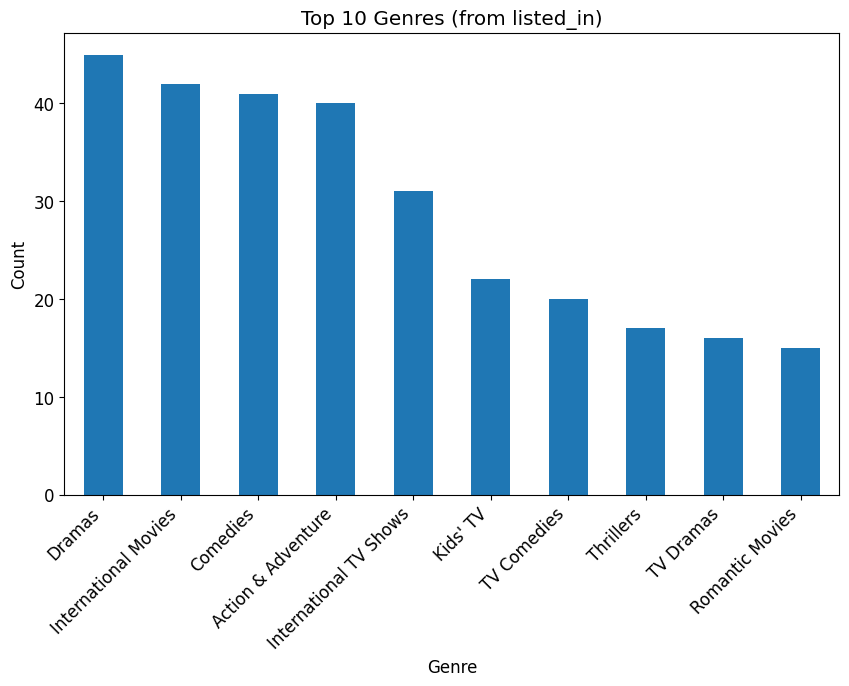

In [15]:
# 12a. Top 20 directors (note some rows have multiple directors separated by commas)
# split directors if multiple values present
def split_directors(s):
    if pd.isna(s):
        return []
    return [d.strip() for d in str(s).split(',') if d.strip()]

directors_expanded = df['director'].dropna().astype(str).apply(split_directors)
all_directors = pd.Series([d for sub in directors_expanded for d in sub])
top_directors = all_directors.value_counts().head(20)
print(top_directors)

# 12b. Genre frequency (listed_in)
all_genres = pd.Series([g for sub in df['genres'] for g in sub])
top_genres = all_genres.value_counts().head(20)
print(top_genres)

# Plot top genres
top_genres.head(10).plot(kind='bar')
plt.title('Top 10 Genres (from listed_in)')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


In [16]:
# 13. Save cleaned DataFrame to CSV for later use or upload to Drive
cleaned_path = 'netflix_cleaned.csv'
df.to_csv(cleaned_path, index=False)
print(f"Cleaned dataset saved to {cleaned_path}")


Cleaned dataset saved to netflix_cleaned.csv
